In [1]:
import pandas as pd
import numpy as np
import os
from filtering_utils import DS_PATH
import fma_code.utils as fma_utils
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None

In [2]:
TRACKS_PATH = os.path.join(DS_PATH, 'tracks_filtered_dummies.csv')
tracks = pd.read_csv(TRACKS_PATH, index_col=0)
tracks.head(10)

,split,subset,Ambient,Ambient Electronic,Avant-Garde,Electroacoustic,Electronic,Experimental,Experimental Pop,Folk,Hip-Hop,Instrumental,Lo-Fi,Noise,Pop,Punk,Rock,Soundtrack
track_id,,,,,,,,,,,,,,,,,,
2,training,small,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,training,medium,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,training,small,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
10,training,small,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
20,training,large,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
26,training,large,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
30,training,large,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
46,training,large,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
48,training,large,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [3]:
AUDIO_PATH = os.path.join(os.getcwd(), 'fma_medium')

viable_tracks_ids = []
for dir_el in os.listdir(AUDIO_PATH):
    if dir_el in ('checksums', 'README.txt'): continue
    for track_filename in os.listdir(os.path.join(AUDIO_PATH, dir_el)):
        while track_filename.startswith('0'):
            track_filename = track_filename[1:]
        viable_tracks_ids.append(int(track_filename.removesuffix('.mp3')))
viable_tracks_ids

[2,
 3,
 5,
 10,
 134,
 136,
 139,
 140,
 141,
 148,
 181,
 182,
 190,
 193,
 194,
 197,
 198,
 200,
 203,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 237,
 247,
 249,
 255,
 256,
 257,
 258,
 341,
 343,
 352,
 368,
 369,
 398,
 399,
 400,
 405,
 414,
 424,
 425,
 458,
 459,
 512,
 534,
 535,
 536,
 537,
 540,
 546,
 550,
 564,
 573,
 583,
 584,
 585,
 590,
 591,
 592,
 593,
 602,
 603,
 605,
 608,
 615,
 619,
 620,
 621,
 625,
 629,
 631,
 633,
 664,
 665,
 666,
 667,
 668,
 669,
 672,
 673,
 674,
 676,
 677,
 679,
 680,
 681,
 684,
 686,
 690,
 694,
 695,
 204,
 397,
 574,
 635,
 696,
 737,
 758,
 814,
 861,
 698,
 701,
 702,
 703,
 704,
 705,
 706,
 707,
 708,
 709,
 714,
 715,
 716,
 717,
 718,
 720,
 734,
 735,
 736,
 738,
 739,
 740,
 741,
 742,
 743,
 744,
 745,
 747,
 748,
 749,
 750,
 751,
 752,
 753,
 754,
 755,
 756,
 757,
 759,
 760,
 761,
 762,
 763,
 764,
 765,
 766,
 767,
 768,
 769,
 770,
 771,
 772,
 773,
 774,
 775,
 776,
 777,
 819,
 820,
 821,
 822,
 823,
 824,
 825,

In [4]:
assert set(viable_tracks_ids).intersection(tracks.index) == set(tracks.index).intersection(viable_tracks_ids)
viable_tracks_ids = list(set(viable_tracks_ids).intersection(tracks.index))
print(tracks.shape)
tracks = tracks.loc[viable_tracks_ids]
tracks.shape

(98988, 18)


(21924, 18)

In [5]:
assert all(idx in viable_tracks_ids for idx in tracks.index)

In [6]:
import librosa.display

sample_audio_path = fma_utils.get_audio_path(AUDIO_PATH, 2)
x, sr = librosa.load(sample_audio_path)
type(x), type(sr)

(numpy.ndarray, int)

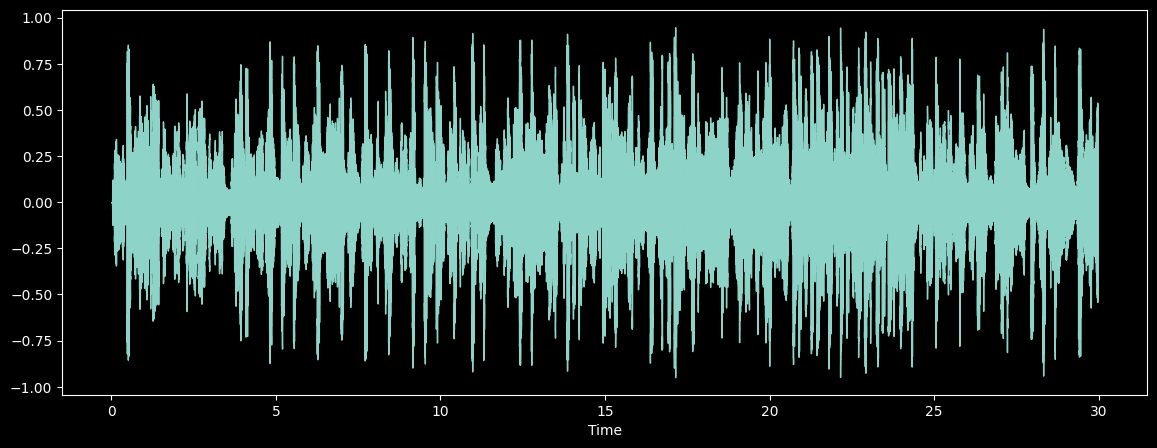

In [7]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

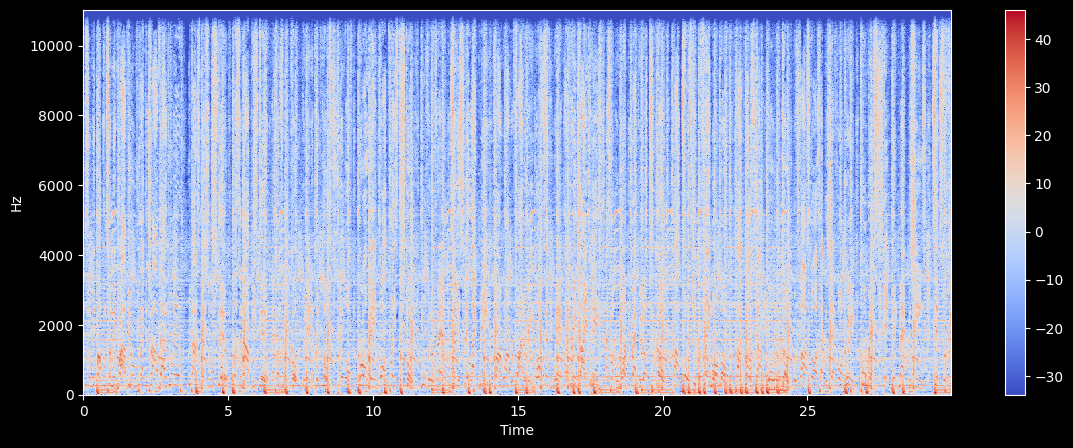

In [8]:
stft = librosa.stft(x)
db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14, 5))
librosa.display.specshow(db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

(20, 1291)


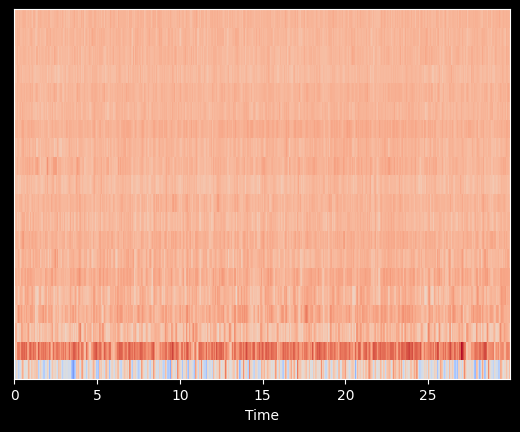

In [9]:
mfccs = librosa.feature.mfcc(y=x, sr=sr)
print(mfccs.shape)
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

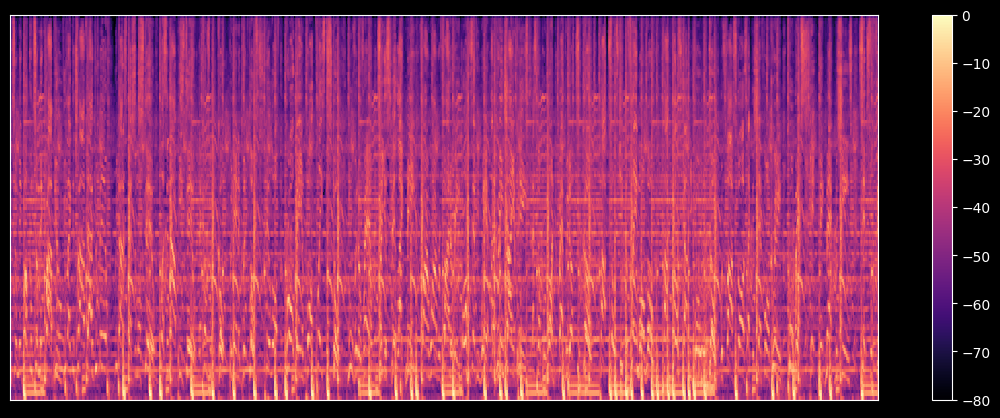

In [10]:
spectr = librosa.feature.melspectrogram(y=x, sr=sr, n_fft=2048, hop_length=512)
spectr = librosa.power_to_db(spectr, ref=np.max)
plt.figure(figsize=(14, 5))
librosa.display.specshow(spectr)
plt.colorbar()

In [11]:
spectr.shape

(128, 1291)

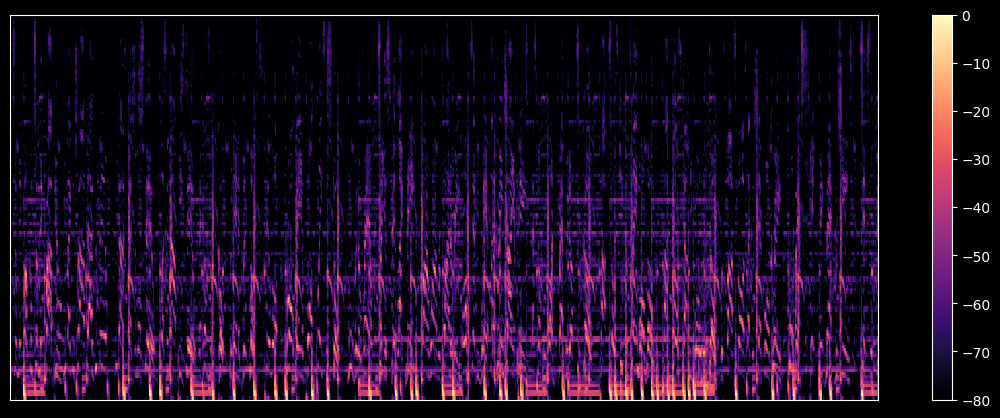

In [12]:
spectr = librosa.feature.melspectrogram(y=x, sr=sr, n_fft=2048, hop_length=512)
spectr = librosa.amplitude_to_db(spectr, ref=np.max)
plt.figure(figsize=(14, 5))
librosa.display.specshow(spectr)
plt.colorbar()

In [13]:
y_tmp, sr = librosa.load(sample_audio_path, duration=3)
len(y_tmp)

66150

(128, 259)


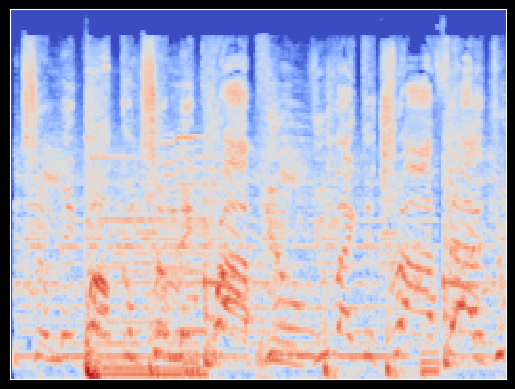

(128, 259)


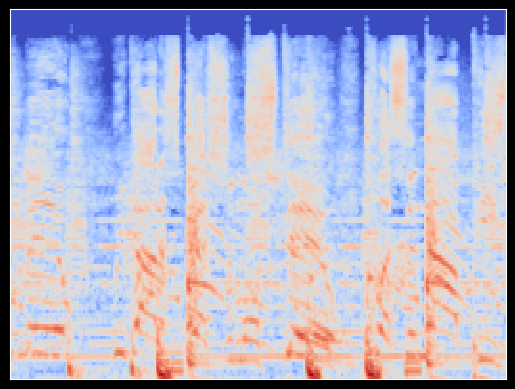

(128, 259)


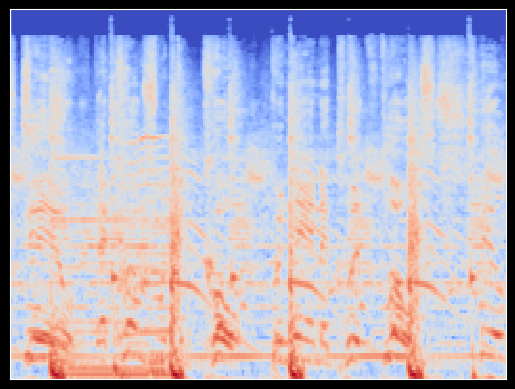

(128, 259)


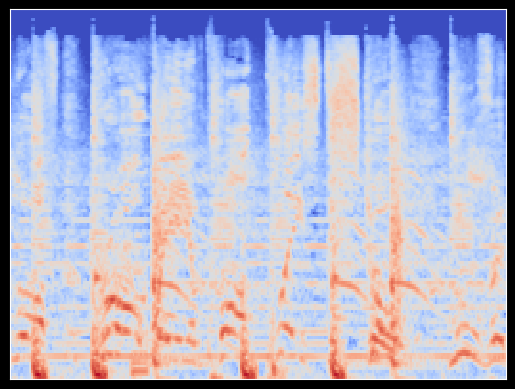

(128, 259)


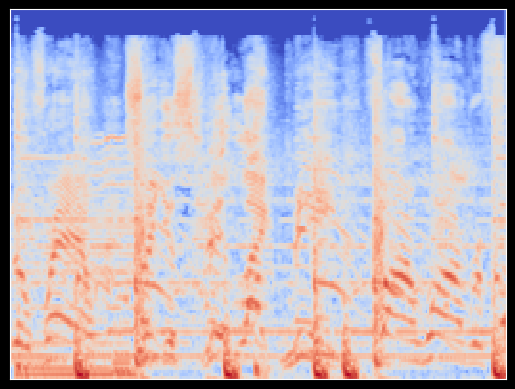

(128, 259)


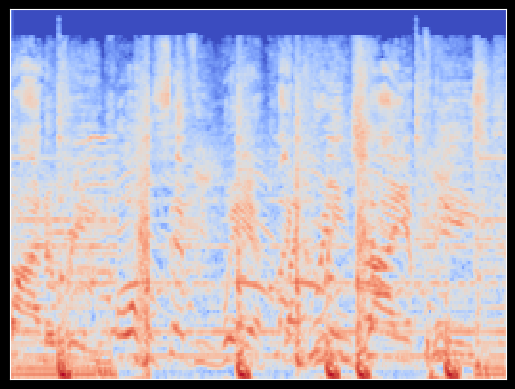

(128, 259)


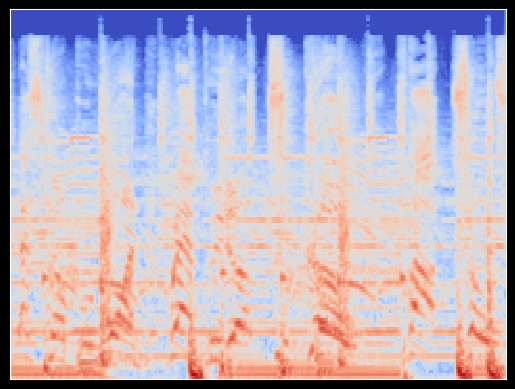

(128, 259)


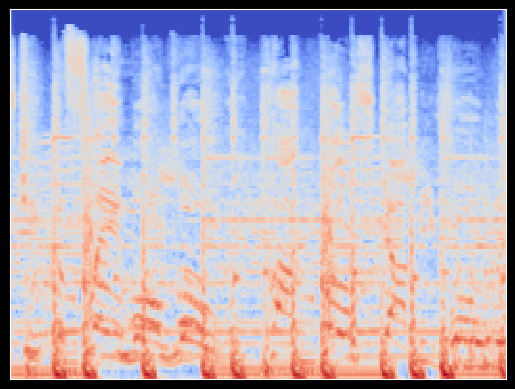

(128, 259)


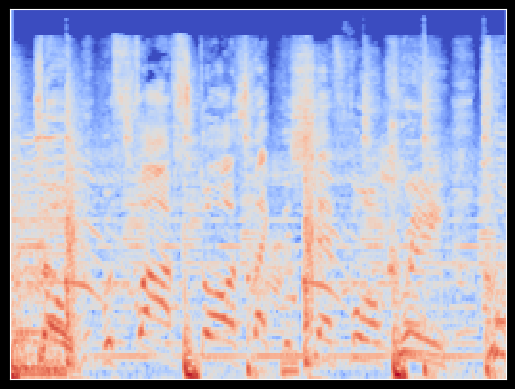

(128, 259)


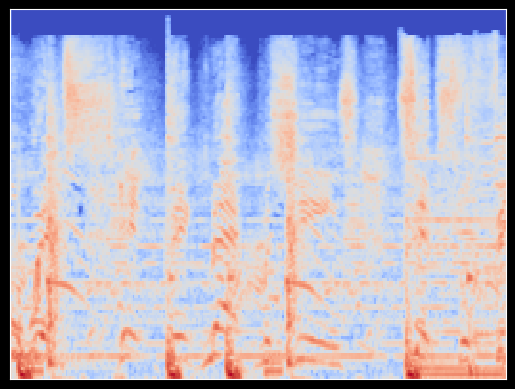

In [14]:
import cnn_model


for spectrogram in cnn_model.generate_track_melspectrograms(track_id=2):
    librosa.display.specshow(
        spectrogram, sr=cnn_model.SAMPLING_RATE,
        hop_length=cnn_model.HOP_LENGTH, n_fft=cnn_model.N_FFT)
    print(spectrogram.shape)
    plt.show()

In [15]:
tracks.reset_index(inplace=True)
tracks.head()

,track_id,split,subset,Ambient,Ambient Electronic,Avant-Garde,Electroacoustic,Electronic,Experimental,Experimental Pop,Folk,Hip-Hop,Instrumental,Lo-Fi,Noise,Pop,Punk,Rock,Soundtrack
0,2,training,small,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,3,training,medium,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,5,training,small,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,10,training,small,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,131119,training,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [16]:
train_ids = tracks[tracks['split'] == 'training']['track_id']
val_ids = tracks[tracks['split'] == 'validation']['track_id']
test_ids = tracks[tracks['split'] == 'test']['track_id']
train_ids.shape, val_ids.shape, test_ids.shape

((17498,), (2193,), (2233,))

In [17]:
train_ids

0             2
1             3
2             5
3            10
4        131119
5        131122
6        131126
7        131127
8        131128
9        131146
10       131153
11       131161
12       131164
13       131166
14       131171
15       131172
16       131177
17       131178
18       131179
19       131180
20       131189
21       131190
22       131191
23       131192
24       131193
25       131194
26       131195
27       131196
28       131197
29          134
30          136
31          139
32          140
33          141
37          190
38          193
39          194
40          197
41          198
42          200
43          203
44          204
45          207
46          208
47          209
48          210
49          211
50          212
51          213
52       131292
53       131303
54          247
55          249
56       131323
57       131324
58       131325
59       131326
60          255
61          256
62          257
63          258
64       131327
65      

In [18]:
label_columns = tracks.drop(['split', 'subset', 'track_id'], axis=1).columns

train_labels = tracks.loc[train_ids.index, label_columns]
val_labels = tracks.loc[val_ids.index, label_columns]
test_labels = tracks.loc[test_ids.index, label_columns]
train_labels.shape, val_labels.shape, test_labels.shape

((17498, 16), (2193, 16), (2233, 16))

In [19]:
train_labels.head()

,Ambient,Ambient Electronic,Avant-Garde,Electroacoustic,Electronic,Experimental,Experimental Pop,Folk,Hip-Hop,Instrumental,Lo-Fi,Noise,Pop,Punk,Rock,Soundtrack
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [23]:
from collections.abc import Generator
from functools import lru_cache
import multiprocessing as mp
import os
import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning, message="librosa.core.audio.__audioread_load")

from audioread.exceptions import NoBackendError
import keras.utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input
from keras.callbacks import EarlyStopping
import librosa
import numpy as np
import pandas as pd
import soundfile as sf

from fma_code import utils as fma_utils

N_FFT = 2048
HOP_LENGTH = 512
SAMPLING_RATE = 44100

AUDIO_PATH = os.path.join(os.getcwd(), 'fma_medium')


def load_audio_file(track_id: int) -> tuple[np.ndarray, int]:
    file_path = fma_utils.get_audio_path(AUDIO_PATH, track_id)
    try:
        return librosa.load(file_path, sr=SAMPLING_RATE, mono=True)
    except (FileNotFoundError, sf.LibsndfileError, NoBackendError) as e:
        return None, None


def trim_audio(audio: np.ndarray) -> np.ndarray:
    return librosa.effects.trim(audio, frame_length=N_FFT, hop_length=HOP_LENGTH)[0]


def calculate_splits_count(audio: np.ndarray, sampling_rate: int = SAMPLING_RATE, split_duration: float = 3.0) -> int:
    total_duration = librosa.get_duration(y=audio, sr=sampling_rate, n_fft=N_FFT, hop_length=HOP_LENGTH)
    return total_duration // split_duration + 1


def split_audio(audio: np.ndarray, sampling_rate: int = SAMPLING_RATE, split_duration: float = 3.0) -> list[np.ndarray]:
    n_splits = calculate_splits_count(audio, sampling_rate, split_duration)
    return np.array_split(audio, n_splits)


def load_melspectrogram(audio: np.ndarray, sampling_rate: int = SAMPLING_RATE) -> np.ndarray:
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sampling_rate, n_fft=2048, hop_length=512)
    return librosa.power_to_db(mel_spectrogram)


def load_mfcc_spectrogram(audio: np.ndarray, sampling_rate: int = SAMPLING_RATE) -> np.ndarray:
    # TODO check implementation
    return librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=20)


@lru_cache(maxsize=512)
def generate_track_melspectrograms(track_id: int, split_duration: float = 3.0) -> Generator[np.ndarray, np.ndarray, None]:
    audio, sampling_rate = load_audio_file(track_id)
    if not isinstance(audio, np.ndarray):
        return None
    trimmed_audio = trim_audio(audio)
    audio_splits = split_audio(trimmed_audio, sampling_rate, split_duration)
    for split in audio_splits:
        yield load_melspectrogram(split, sampling_rate)


@lru_cache(maxsize=512)
def generate_track_mfcc_spectrograms(track_id: int, split_duration: float = 3.0) -> Generator[np.ndarray, np.ndarray, None]:
    audio, sampling_rate = load_audio_file(track_id)
    if not isinstance(audio, np.ndarray):
        return None
    trimmmed_audio = trim_audio(audio)
    audio_splits = split_audio(trimmmed_audio, sampling_rate, split_duration)
    for split in audio_splits:
        yield load_mfcc_spectrogram(split, sampling_rate)


class SpectrogramGenerator(keras.utils.Sequence):
    _N_FFT = N_FFT
    _HOP_LENGTH = HOP_LENGTH
    _SAMPLING_RATE = SAMPLING_RATE

    def __init__(
            self,
            track_ids: pd.Series,
            labels: pd.DataFrame,
            sample_duration: float = 3.0,
            batch_size: int = 128,
            spectrogram_dimensions: tuple[int, int] = (128, 130),
            shuffle: bool = True
        ) -> None:
        self._track_ids = track_ids
        self._labels = labels
        self._sample_duration = sample_duration
        self._batch_size = batch_size
        self._spectrogram_dimensions = spectrogram_dimensions
        self._shuffle = shuffle
        self._invalid_tracks_ids = []
        self.on_epoch_end()
    
    def __len__(self) -> int:
        return int(np.floor(len(self._track_ids) / self._batch_size))
    
    def on_epoch_end(self) -> None:
        self._indexes = np.array(self._track_ids.index)
        if self._shuffle:
            np.random.shuffle(self._indexes)
        self._drop_invalid_tracks_ids()
    
    def _drop_invalid_tracks_ids(self) -> None:
        if not self._invalid_tracks_ids:
            return
        self._current_tracks_ids = self._current_tracks_ids.drop(self._invalid_tracks_ids)
        self._track_ids = self._track_ids.drop(self._invalid_tracks_ids)
        self._invalid_tracks_ids = []
    
    def __getitem__(self, index: int) -> tuple[np.ndarray | np.ndarray]:
        indexes = self._indexes[index * self._batch_size: (index + 1) * self._batch_size]
        self._current_tracks_ids = self._track_ids.loc[indexes].index
        
        X = []
        y= []

        with mp.Pool(os.cpu_count()) as pool:
            for current_track_id in self._current_tracks_ids:
                current_track_spectrograms = pool.apply(self._generate_valid_spectrograms_for_track, args=(current_track_id,))

                if not current_track_spectrograms:
                    self._invalid_tracks_ids.append(current_track_id)
                    continue
                X.extend(current_track_spectrograms)

                current_track_genre = self._labels.loc[current_track_id].values
                for _ in range(len(current_track_spectrograms)):
                    y.append(current_track_genre)

        assert len(X) != 0, 'No tracks ids to get, something went wrong!'
        return np.asarray(X), np.array(y)
    
    def _generate_valid_spectrograms_for_track(self, current_track_id) -> Generator[np.ndarray, np.ndarray]:
        current_track_spectrograms = []
        current_track_spectrograms_generator = generate_track_melspectrograms(current_track_id, self._sample_duration)

        if not current_track_spectrograms_generator:
            return current_track_spectrograms
        
        for current_track_spectrogram in current_track_spectrograms_generator:
            if current_track_spectrogram.shape != self._spectrogram_dimensions:
                current_track_spectrogram = np.resize(current_track_spectrogram, self._spectrogram_dimensions)
            current_track_spectrogram = np.expand_dims(current_track_spectrogram, axis=-1)
            current_track_spectrograms.append(current_track_spectrogram)

        return current_track_spectrograms


def create_model(labels_count: int, spectrogram_dimensions: tuple[int, int], channels: int) -> Sequential:
    model = Sequential([
        Input(shape=(*spectrogram_dimensions, channels,)),
        Conv2D(16, kernel_size=2, strides=2, activation='relu'),
        MaxPooling2D(),
        Conv2D(16, kernel_size=2, strides=2, activation='relu'),
        MaxPooling2D(),
        Conv2D(32, kernel_size=2, strides=2, activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(labels_count, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())

    return model


def validate_labels_count(train_labels: pd.DataFrame, val_labels: pd.DataFrame, test_labels: pd.DataFrame):
    train_labels_count = train_labels.shape[1]
    val_labels_count = val_labels.shape[1]
    test_labels_count = test_labels.shape[1]
    assert train_labels_count == val_labels_count == test_labels_count, \
        f'Labels count is not equal: train={train_labels_count}, val={val_labels_count}, test={test_labels_count}'


def train_model(
        train_ids: list[int],
        val_ids: list[int],
        test_ids: list[int],
        train_labels: pd.DataFrame,
        val_labels: pd.DataFrame,
        test_labels: pd.DataFrame,
        sample_duration: float = 3.0,
        spectrogram_dimensions: tuple[int, int] = (128, 130),
        channels: int = 1,
        batch_size: int = 128,
        shuffle: bool = True) -> None:
    validate_labels_count(train_labels, val_labels, test_labels)

    model = create_model(train_labels.shape[1], spectrogram_dimensions, channels)

    train_generator = SpectrogramGenerator(train_ids, train_labels, sample_duration, batch_size, spectrogram_dimensions, shuffle)
    val_generator = SpectrogramGenerator(val_ids, val_labels, sample_duration, batch_size, spectrogram_dimensions, shuffle)
    test_generator = SpectrogramGenerator(test_ids, test_labels, sample_duration, batch_size, spectrogram_dimensions, shuffle)

    early_stopping = EarlyStopping(patience=7, restore_best_weights=True)
    model.fit(
        train_generator,
        validation_data=val_generator,
        batch_size=batch_size,
        epochs=100,
        callbacks=[early_stopping],
        verbose=2
    )

    print(model.evaluate(test_generator))


train_model(train_ids, val_ids, test_ids, train_labels, val_labels, test_labels)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 64, 65, 16)        80        
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 16)        1040      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 8, 8, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 32)          2080      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 2, 2, 32)        

[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (3264) too large for available bit count (3224)
[src/libmpg123/layer3.c:INT123_do_layer3():1841] error: dequantization failed!
[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!


KeyError: '[6750, 5416, 20237, 15929, 3662, 7609, 3644, 6546, 16468, 21015, 18354, 11547, 12092, 12542, 3280, 13614, 12731, 8486, 1781, 1566, 12540, 8678, 3650, 21477, 20356, 9224, 14321, 2858, 8562, 4058, 4900, 15016, 18203, 20173, 15918, 5234, 8667, 9576, 11736, 9000, 6833, 9145, 18232, 8651, 5857, 7607, 11749, 10188, 12822, 17388, 7678, 19880, 17969, 11692, 20626, 2842, 15832, 9196, 161, 15921, 3099, 6923, 15169, 9632, 12103, 17266, 9203, 5296, 21466, 6493, 19851, 12909, 2459, 21469, 10752, 3600, 7767, 17063, 12097, 12713, 7820, 9098, 11706, 6977, 8177, 7650, 13858, 21014, 329, 20392, 20575, 19882, 5297, 12027, 10392, 15927, 18230, 1258, 9952, 1774, 1471, 6711, 6750, 5416, 20237, 15929, 3662, 7609, 3644, 6546, 16468, 21015, 18354, 11547, 12092, 12542, 3280, 13614, 12731, 8486, 1781, 1566, 12540, 8678, 3650, 21477, 20356, 9224, 14321, 2858, 8562, 4058, 4900, 15016, 18203, 20173, 15918, 5234, 8667, 9576, 11736, 9000, 6833, 9145, 18232, 8651, 5857, 7607, 11749, 10188, 12822, 17388, 7678, 19880, 17969, 11692, 20626, 2842, 15832, 9196, 161, 15921, 3099, 6923, 15169, 9632, 12103, 17266, 9203, 5296, 21466, 6493, 19851, 12909, 2459, 21469, 10752, 3600, 7767, 17063, 12097, 12713, 7820, 9098, 11706, 6977, 8177, 7650, 13858, 21014, 329, 20392, 20575, 19882, 5297, 12027, 10392, 15927, 18230, 1258, 9952, 1774, 1471, 6711, 8484, 1867, 4485, 8076, 19578, 3783, 479, 3451, 21097, 3601, 11943, 18455, 17618, 13611, 5414, 8316, 15138, 16856, 4899, 21095, 115, 15917, 21606, 12280, 16085, 19883, 8898, 1985, 480, 14555, 7594, 6751, 10183, 21048, 4725, 5262, 9865, 11224, 3415, 8065, 2186, 6015, 6012, 19990, 10292, 8083, 13859, 9577, 13705, 17386, 20072, 18459, 19985, 5566, 451, 1801, 14464, 20622, 9200, 10949, 17162, 8679, 19876, 11744, 20355, 6866, 3286, 21089, 14557, 10604, 21287, 19106, 9204, 15930, 4179, 1864, 3790, 8654, 11249, 4897, 19194, 8958, 15325, 14329, 13714, 8912, 16109, 21018, 10242, 7592, 8956, 17823, 12784, 8049, 17061, 17385, 2448, 7239, 11707, 3742, 14599, 13033, 4488, 1968, 21600, 1714, 16248, 16956, 12715, 16106, 13532, 3674, 14372, 6578, 4425, 20693, 4728, 14228, 13340, 482, 14332, 20358, 7623, 20122, 21597, 15014, 21291, 19774, 172, 15024, 20120, 18742, 7236, 9221, 15830, 7190, 12787, 12732, 9807, 20980, 1974, 1713, 3645, 21096, 15716, 6869, 21483, 6035, 7191, 944, 10391, 21603, 7185, 7127, 10131, 21745, 8966, 3277, 19193, 9398, 16251, 2992, 4726, 17834, 13616, 16087, 12302, 9724, 12785, 16440, 297, 440, 6872, 13686, 3293, 18825, 9637, 8731, 7621, 4894, 18675, 16859, 6925, 5806, 16260, 16857, 7134, 13704, 15249, 19984, 331, 14852, 8709, 18741, 3642, 5856, 5066, 21286, 19854, 20983, 1796, 17835, 9813, 7256, 19881, 3712, 4379, 20986, 6868, 14546, 13534, 8063, 12711, 8661, 19850, 4973, 12036, 1723, 8957, 5070, 7188, 20125, 14199, 9002, 21381, 17247, 17384, 6976, 16257, 3678, 17389, 7920, 11000, 3550, 19190, 9812, 3141, 12282, 396, 7186, 2185, 1860, 17673, 14914, 15137, 8079, 16259, 6359, 3281, 8970, 15570, 10607, 16105, 10185, 18353, 13676, 4296, 13698, 21103, 13486, 9382, 7234, 8176, 16861, 18231, 2077, 4866, 4001, 21467, 3597, 2993, 10605, 12657, 10606, 2026, 5554, 14827, 14136, 8072, 12734, 4494, 13553, 14635, 8503, 10106, 8318, 9809, 938, 21472, 13092, 18319, 12727, 1709, 21413, 1261, 21350, 4789, 6867, 7617, 7614, 937, 3671, 21273, 3142, 909, 21088, 943, 8942, 16446, 3780, 10245, 19454, 912, 8073, 20763, 12729, 16862, 5298, 1264, 13683, 3295, 9197, 3647, 19862, 13429, 12119, 5064, 19977, 10294, 9950, 13703, 4489, 8069, 3769, 7244, 5887, 15456, 12264, 18598, 6147, 6488, 5855, 10491, 11253, 18829, 12794, 3797, 300, 18590, 17416, 13552, 7174, 16194, 15181, 19979, 19531, 3649, 10841, 8084, 18828, 14902, 21392, 7157, 8075, 19992, 12031, 4479, 9045, 6547, 9820, 3710, 7625, 2567, 12963, 19189, 7905, 17114, 14560, 7176, 7165, 15454, 3663, 9633, 7237, 4272, 2193, 15849, 133, 19991, 17871, 21865, 15926, 15571, 8182, 11928, 17164, 1473, 15455, 11145, 17390, 14203, 8824, 1858, 8866, 12826, 19675, 4290, 11048, 17832, 12094, 2536, 11747, 16466, 15587, 4546, 7257, 3418, 8175, 21285, 3760, 18461, 6246, 15583, 7323, 11004, 14138, 17267, 9222, 14598, 1861, 20988, 20989, 12783, 4547, 13682, 14915, 11007, 11058, 13485, 20124, 9657, 298, 6678, 21098, 11223, 5461, 3738, 20118, 6926, 122, 1806, 14201, 10393, 19191, 10179, 9223, 4426, 4550, 9953, 8062, 21478, 4878, 2560, 6254, 4831, 12278, 8396, 12246, 14747, 20690, 2565, 6255, 6804, 18277, 9208, 19440, 20236, 15135, 10049, 6871, 6205, 20982, 11741, 13687, 21602, 3773, 12028, 4282, 20987, 4727, 17248, 9194, 18282, 14905, 7271, 7187, 3166, 15453, 11735, 5112, 12029, 13702, 7238, 3768, 11442, 7150, 9635, 11003, 5804, 4548, 9383, 14333, 14903, 20619, 13520, 7241, 13453, 20123, 13826, 19855, 4503, 16247, 6124, 1973, 19980, 4552, 21703, 1437, 8060, 10688, 4528, 15250, 10750, 4527, 7243, 9954, 15247, 14606, 8849, 5419, 21290, 16534, 21094, 11108, 12541, 6049, 16192, 34, 17245, 8078, 10907, 14554, 4731, 7572, 21411, 21102, 18281, 15572, 10123, 1505, 1986, 12735, 20170, 20689, 6252, 911, 20828, 21101, 301, 13692, 18670, 21356, 4504, 12712, 8655, 8320, 6543, 19677, 21090, 21093, 17116, 4885, 16860, 4734, 18205, 9193, 10371, 21412, 13689, 15843, 20117, 18674, 18460, 8854, 7135, 8319, 20990, 691, 6927, 16250, 6195, 10988, 12655, 2198, 16419, 1458, 15060, 12714, 16957, 14535, 848, 3417, 9864, 4901, 21485, 4895, 11745, 5853, 19863, 8664, 18356, 4832, 6978, 10572, 12795, 21482, 12717, 21017, 8757, 1263, 12039, 3181, 15831, 14702, 13432, 170, 11279, 12250, 21601, 5730, 12819, 20981, 5462, 3651, 10548, 11106, 7227, 15845, 19196, 12656, 13679, 9755, 13467, 8657, 3575, 1857, 20898, 17062, 7254, 15848, 452, 1472, 8472, 12564, 4902, 1478, 8946, 6247, 2570, 1866, 9819, 21355, 3148, 19987, 18673, 15553, 14545, 377, 14550, 8470, 13824, 7133, 4497, 5415, 20393, 4380, 18204, 162, 14461, 15251, 13678, 3431, 1257, 3646, 15715, 2078, 5110, 375, 530, 11220, 2629, 1990, 14851, 19676, 1477, 5748, 21012, 12796, 13333, 3147, 15017, 18394, 13675, 16193, 4551, 8181, 4735, 4889, 1805, 11008, 11684, 13823, 6011, 8563, 20121, 17415, 1779, 21010, 21604, 5546, 4278, 3235, 2564, 16256, 7610, 8728, 19875, 20985, 14355, 21383, 1457, 9207, 13690, 1475, 13693, 20240, 9720, 7921, 8960, 4898, 3143, 7619, 15104, 6541, 5261, 15747, 6014, 1802, 18758, 17617, 3711, 17144, 18457, 3734, 7240, 17101, 5067, 14423, 14331, 116, 8662, 8070, 21380, 481, 1595, 16854, 15026, 21473, 12030, 11092, 17060, 20352, 7821, 2284, 7255, 15912, 10290, 3549, 20171, 19874, 114, 14229, 171, 15246, 18677, 7626, 7611, 1493, 15555, 15015, 13825, 4178, 7765, 3285, 17127, 1456, 2360, 14200, 3278, 14904, 2559, 13259, 8666, 296, 411, 7620, 1859, 21239, 17246, 8959, 15107, 8961, 19088, 12736, 3770, 373, 15175, 21479, 11005, 19579, 10394, 11743, 21700, 8999, 18599, 9661, 7612, 10609, 12040, 15585, 11221, 4427, 16189, 13701, 18395, 10369, 1800, 2863, 7615, 12825, 1260, 5901, 15329, 20623, 14373, 2884, 7245, 13694, 21289, 13466, 9578, 4880, 1710, 10927, 12100, 15569, 14457, 20785, 13716, 6834, 11742, 12245, 9069, 1139, 17304, 8944, 2561, 2563, 21486, 2568, 7618, 8068, 17616, 7994, 10182, 688, 4487, 12091, 6928, 20620, 21354, 4295, 4732, 15027, 20350, 14551, 1777, 3026, 8487, 8727, 16855, 19339, 10291, 850, 9202, 16108, 12037, 2569, 1513, 7766, 8825, 11746, 4482, 14548, 4483, 18202, 3599, 5548, 13430, 20559, 687, 15922, 20516, 7160, 14134, 15166, 15924, 12726, 1970, 7304, 20958, 15103, 21357, 7159, 21091, 9564, 12728, 4502, 12962, 662, 4891, 9814, 8949, 8758, 20691, 2157, 13700, 6974, 3296, 3576, 8729, 14137, 9951, 17305, 3714, 16253, 15925, 4477, 3283, 9205, 13677, 1987, 12545, 15028, 20119, 14561, 8656, 5412, 21705, 13458, 3279, 1200, 307, 21394, 16088, 9810, 16086, 8971, 13699, 15684, 15844, 10181, 13681, 3665, 7260, 13100, 3841, 20515, 2184, 1476, 20238, 11045, 13612, 4259, 8321, 20694, 13691, 2885, 449, 942, 2156, 13620, 8525, 123, 7613, 9003, 7573, 7235, 3416, 5418, 20239, 478, 19076, 16246, 15556, 5233, 6386, 15714, 5236, 2080, 13695, 4480, 5805, 2670, 10751, 21470, 15029, 9821, 11693, 2669, 9206, 15915, 1262, 330, 324, 14371, 3999, 5545, 10608, 19884, 8682, 21484, 21393, 2028, 1776, 19104, 21747, 851, 15189, 12093, 6253, 118, 6975, 14597, 294, 4481, 16417, 10523, 18357, 4921, 21099, 13759, 5520, 8524, 1803, 9210, 447, 18280, 910, 3664, 17672, 852, 4896, 328, 14613, 14804, 16297, 10133, 4303, 5803, 11251, 20394, 6870, 16252, 4890, 19861, 13688, 8526, 9723, 2606, 2991, 163, 14410, 16084, 3149, 16258, 14612, 6929, 4478, 19988, 20242, 15687, 12733, 6036, 6930, 7922, 6248, 17615, 13464, 21367, 1715, 10177, 10840, 11441, 4944, 8077, 12824, 10178, 14197, 13431, 14703, 8317, 1511, 10390, 20359, 21016, 13428, 13713, 9309, 20688, 3282, 4498, 1462, 3145, 10928, 3466, 10126, 20625, 15328, 8468, 1479, 10293, 847, 16254, 16255, 21365, 5111, 15013, 18276, 14232, 9737, 21481, 13680, 3290, 8074, 486, 16728, 13621, 17417, 10838, 21471, 306, 20514, 18456, 13618, 4736, 15923, 21100, 21288, 16418, 10122, 9818, 6796, 13554, 20960, 20354, 8669, 12032, 6835, 2859, 5411, 15552, 2154, 7158, 11944, 1501, 1590, 483, 13484, 15168, 936, 8653, 8705, 8435, 14995, 15717, 2153, 8184, 20243, 20116, 17413, 1490, 8668, 9192, 1565, 1868, 17674, 16188, 12719, 3291, 18672, 9399, 4892, 2029, 15574, 17163, 13617, 11926, 16958, 17833, 2860, 450, 21019, 7242, 9805, 20241, 18279, 7431, 20391, 16467, 1589, 3648, 11046, 6922, 849, 14552, 2668, 10950, 7183, 16469, 1972, 8471, 8650, 17143, 17574, 18396, 20512, 12244, 12543, 1512, 12781, 18597, 4553, 3275, 8183, 20788, 7303, 3318, 14544, 7686, 10837, 10835, 10283, 4010, 1136, 8659, 299, 9754, 3414, 3294, 12730, 9636, 19340, 14230, 8677, 12281, 19983, 6979, 15326, 9955, 12104, 11927, 15920, 15928, 13685, 4879, 448, 21748, 6000, 15324, 13947, 15136, 8652, 18278, 19075, 21746, 18458, 20560, 9806, 15914, 18359, 15919, 946, 13715, 3456, 20562, 6818, 18206, 21379, 15847, 295, 13613, 4887, 21599, 21341, 17947, 17831, 9225, 15916, 4486, 3653, 8730, 10955, 15557, 5299, 484, 9665, 17578, 16107, 18826, 3660, 12782, 7995, 4877, 1848, 5729, 13483, 14462, 1480, 15170, 7536, 4865, 20040, 13465, 15025, 16840, 20624, 9416, 20080, 12099, 18669, 19502, 20758, 14994, 1869, 15685, 7593, 4733, 3440, 16191, 4549, 3289, 13712, 1988, 908, 14913, 12098, 2079, 5854, 4729, 13615, 8769, 4943, 15586, 12248, 4019, 7258, 1862, 14398, 20561, 8469, 15584, 9822, 2562, 8680, 1198, 20621, 3771, 11110, 9201, 20245, 18360, 11104, 11006, 7233, 746, 8658, 21598, 4790, 3643, 21791, 15018, 15323, 8733, 19981, 19877, 3292, 14947, 15167, 20390, 7228, 4893, 14421, 6251, 374, 14600, 1474, 10839, 5232, 17414, 2886, 4495, 5417, 8082, 17822, 12247, 21009, 5547, 21487, 15575, 2158, 17614, 14701, 6013, 19195, 10842, 14705, 7996, 13256, 12038, 9001, 12101, 7231, 9862, 8066, 5890, 7608, 18676, 14139, 16858, 2454, 1778, 20660, 3774, 13684, 3592, 1991, 7627, 8649, 14549, 8485, 2462, 13674, 8707, 14553, 12544, 1992, 8732, 5413, 3144, 17128, 117, 308, 3287, 945, 7651, 20353, 17575, 8434, 20172, 8067, 4545, 19580, 14704, 20351, 20574, 7189, 15313, 21704, 11252, 14993, 12718, 18591, 3652, 19747, 11109, 7761, 20357, 1780, 3800, 13513, 8708, 6197, 7595, 4886, 13697, 11105, 21092, 376, 3998, 13696, 12279, 8663, 7184, 1499, 8660, 18827, 8947, 12102, 21468, 9660, 18361, 11107, 485, 14608, 15245, 529, 3146, 1969, 13619, 5113, 19853, 11047, 3577, 19852, 9198, 16470, 4730, 11001, 10953, 168, 293, 8848, 17115, 15248, 16249, 20661, 8315, 1593, 7822, 21605, 1242, 12446, 1711] not found in axis'